In [1]:
from math import sin, cos, pi

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

%matplotlib inline

## Исходные данные (объемы пассажирских авиаперевозок)

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col=0, parse_dates=True)
passengers.head()

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


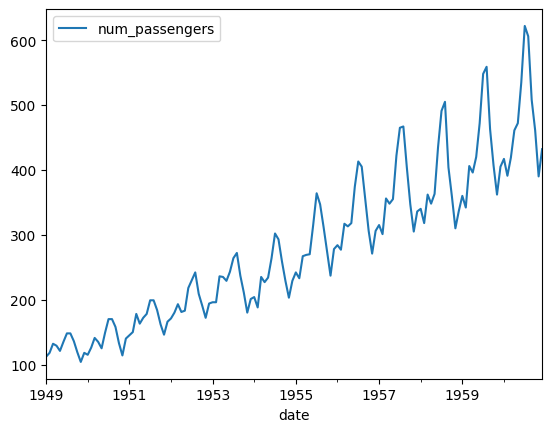

In [3]:
passengers.plot()
plt.show()

## 1. Модель линейной регрессии, учитывающую линейный тренд и аддитивную сезонность

In [4]:
passengers['const'] = 1

passengers['t'] = range(0, passengers.shape[0])

passengers['sin(2pi*(i-1)/s)'] = [sin(2 * pi * (i-1) / 12) for i in passengers['t'].values]
passengers['cos(2pi*(i-1)/s)'] = [cos(2 * pi * (i-1) / 12) for i in passengers['t'].values]

In [5]:
passengers.head()

,num_passengers,const,t,sin(2pi*(i-1)/s),cos(2pi*(i-1)/s)
date,,,,,
1949-01-01,112,1,0,-0.500000,8.660254e-01
1949-02-01,118,1,1,0.000000,1.000000e+00
1949-03-01,132,1,2,0.500000,8.660254e-01
1949-04-01,129,1,3,0.866025,5.000000e-01
1949-05-01,121,1,4,1.000000,6.123234e-17


In [6]:
linregr = sm.GLM(endog=passengers['num_passengers'].values, 
                 exog=passengers.drop('num_passengers', axis=1).values, 
                 family=sm.families.Gaussian()).fit()

In [7]:
linregr.params

array([ 90.83234342,   2.64987787,  27.44903631, -36.69061065])

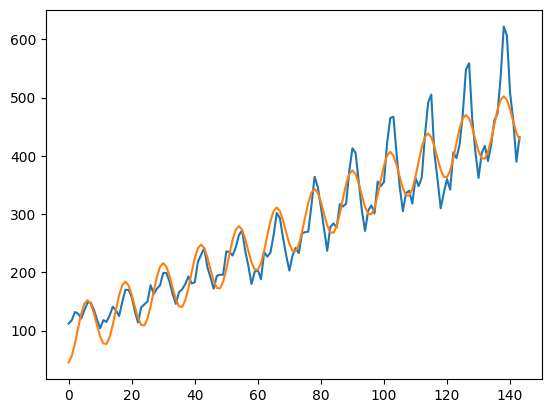

In [8]:
plt.plot(passengers['num_passengers'].values)
plt.plot(linregr.fittedvalues)
plt.show()

### Прогноз модели

In [9]:
passengers_forecast = pd.DataFrame(index=pd.date_range('1949-01-01', '1963-12-01', freq='MS'))

In [10]:
passengers_forecast['const'] = 1

passengers_forecast['t'] = range(0, passengers_forecast.shape[0])

passengers_forecast['sin(2pi*(i-1)/s)'] = [sin(2 * pi * (i-1) / 12) for i in passengers_forecast['t'].values]
passengers_forecast['cos(2pi*(i-1)/s)'] = [cos(2 * pi * (i-1) / 12) for i in passengers_forecast['t'].values]

In [11]:
passengers_forecast['num_passengers'] = linregr.predict(passengers_forecast)

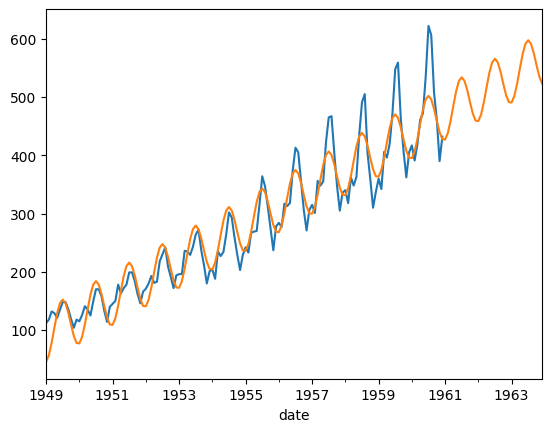

In [12]:
passengers['num_passengers'].plot()
passengers_forecast['num_passengers'].plot()
plt.show()

### Остатки модели: являются ли они стационарным рядом?

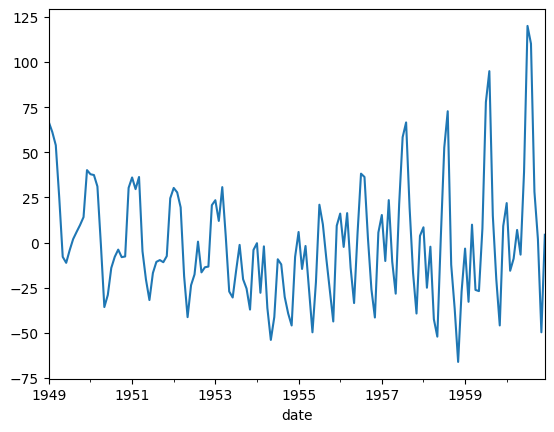

In [13]:
resids = (passengers['num_passengers'] - passengers_forecast['num_passengers']['1949-01-01':'1960-12-01'])
resids.plot()
plt.show()

In [14]:
adfuller(resids)[1]

0.21918044671455045

p-value > 0.05, остатки не являются стационарным рядом на уровне значимости 5%.

# 2. Модель с учетом мультипликативной сезонности ряда

In [15]:
passengers['t*sin'] = [passengers['t'].values[i] * passengers['sin(2pi*(i-1)/s)'].values[i] for i in range(passengers.shape[0])]
passengers['t*cos'] = [passengers['t'].values[i] * passengers['cos(2pi*(i-1)/s)'].values[i] for i in range(passengers.shape[0])]

In [16]:
passengers.head()

,num_passengers,const,t,sin(2pi*(i-1)/s),cos(2pi*(i-1)/s),t*sin,t*cos
date,,,,,,,
1949-01-01,112,1,0,-0.500000,8.660254e-01,-0.000000,0.000000e+00
1949-02-01,118,1,1,0.000000,1.000000e+00,0.000000,1.000000e+00
1949-03-01,132,1,2,0.500000,8.660254e-01,1.000000,1.732051e+00
1949-04-01,129,1,3,0.866025,5.000000e-01,2.598076,1.500000e+00
1949-05-01,121,1,4,1.000000,6.123234e-17,4.000000,2.449294e-16


In [17]:
linregr = sm.GLM(endog=passengers['num_passengers'].values, 
                 exog=passengers.drop('num_passengers', axis=1).values, 
                 family=sm.families.Gaussian()).fit() # что и по чему прогнозируем

In [18]:
linregr.params

array([90.22861875,  2.65171109,  9.36162565,  5.30094559,  0.24955061,
       -0.59555387])

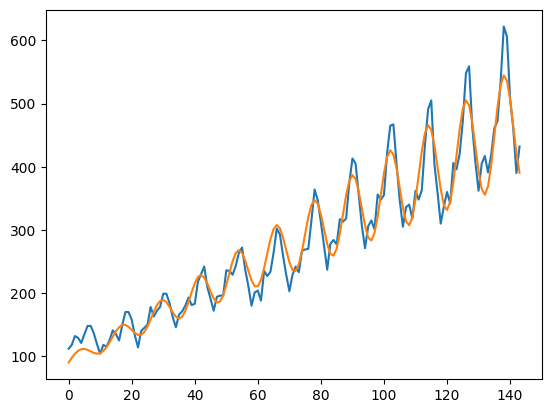

In [19]:
plt.plot(passengers['num_passengers'].values)
plt.plot(linregr.fittedvalues)
plt.show()

### Прогноз модели, учитывающей мультипликативную сезонность

In [20]:
passengers_forecast['t*sin'] = [passengers_forecast['t'].values[i] * passengers_forecast['sin(2pi*(i-1)/s)'].values[i] for i in range(passengers_forecast.shape[0])]
passengers_forecast['t*cos'] = [passengers_forecast['t'].values[i] * passengers_forecast['cos(2pi*(i-1)/s)'].values[i] for i in range(passengers_forecast.shape[0])]

In [21]:
passengers_forecast['num_passengers'] = linregr.predict(passengers_forecast.drop('num_passengers', axis=1))

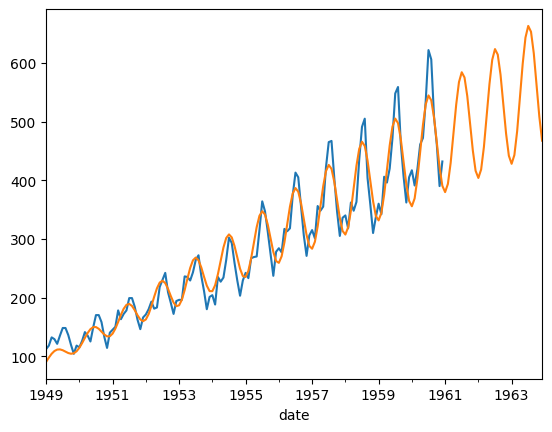

In [22]:
passengers['num_passengers'].plot()
passengers_forecast['num_passengers'].plot()
plt.show()

### Остатки модели с учетом мультипликативной сезонности ряда: являются ли они стационарным рядом в этом случае?

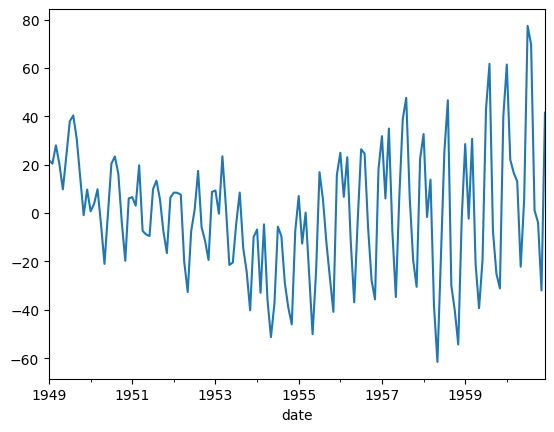

In [23]:
resids = (passengers['num_passengers'] - passengers_forecast['num_passengers']['1949-01-01':'1960-12-01'])
resids.plot()
plt.show()

In [24]:
adfuller(resids)[1]

0.457308651188221

p-value > 0.05, остатки до сих пор не являются стационарным рядом.

## 3. Модель с добавлением квадратичного тренда

In [25]:
passengers['t^2'] = [passengers['t'].values[i]**2 for i in range(passengers.shape[0])]

passengers['t^2*sin'] = [passengers['t^2'].values[i] * passengers['sin(2pi*(i-1)/s)'].values[i] for i in range(passengers.shape[0])]
passengers['t^2*cos'] = [passengers['t^2'].values[i] * passengers['cos(2pi*(i-1)/s)'].values[i] for i in range(passengers.shape[0])]

In [26]:
passengers.head()

,num_passengers,const,t,sin(2pi*(i-1)/s),cos(2pi*(i-1)/s),t*sin,t*cos,t^2,t^2*sin,t^2*cos
date,,,,,,,,,,
1949-01-01,112,1,0,-0.500000,8.660254e-01,-0.000000,0.000000e+00,0,-0.000000,0.000000e+00
1949-02-01,118,1,1,0.000000,1.000000e+00,0.000000,1.000000e+00,1,0.000000,1.000000e+00
1949-03-01,132,1,2,0.500000,8.660254e-01,1.000000,1.732051e+00,4,2.000000,3.464102e+00
1949-04-01,129,1,3,0.866025,5.000000e-01,2.598076,1.500000e+00,9,7.794229,4.500000e+00
1949-05-01,121,1,4,1.000000,6.123234e-17,4.000000,2.449294e-16,16,16.000000,9.797174e-16


In [27]:
linregr = sm.GLM(endog=passengers['num_passengers'].values, 
                 exog=passengers.drop('num_passengers', axis=1).values, 
                 family=sm.families.Gaussian()).fit()

In [28]:
linregr.params

array([ 1.13057309e+02,  1.69796089e+00,  1.11765059e+01, -5.07212888e+00,
        1.05480614e-01, -2.22784605e-01,  6.64781787e-03,  1.24375387e-03,
       -2.38627620e-03])

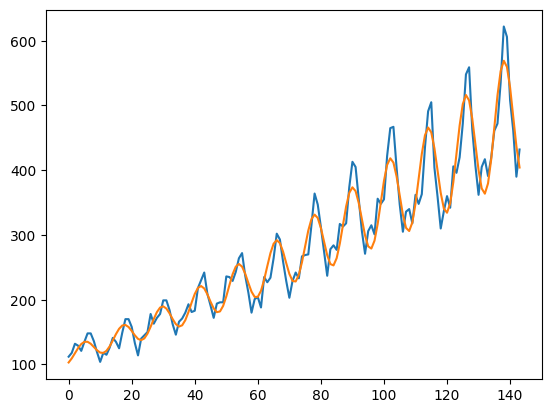

In [29]:
plt.plot(passengers['num_passengers'].values)
plt.plot(linregr.fittedvalues)
plt.show()

## Прогноз модели с добавлением квадратичного тренда

In [30]:
passengers_forecast['t^2'] = [passengers_forecast['t'].values[i]**2 for i in range(passengers_forecast.shape[0])]

passengers_forecast['t^2*sin'] = [passengers_forecast['t^2'].values[i] * passengers_forecast['sin(2pi*(i-1)/s)'].values[i] for i in range(passengers_forecast.shape[0])]
passengers_forecast['t^2*cos'] = [passengers_forecast['t^2'].values[i] * passengers_forecast['cos(2pi*(i-1)/s)'].values[i] for i in range(passengers_forecast.shape[0])]

In [31]:
passengers_forecast['num_passengers'] = linregr.predict(passengers_forecast.drop('num_passengers', axis=1))

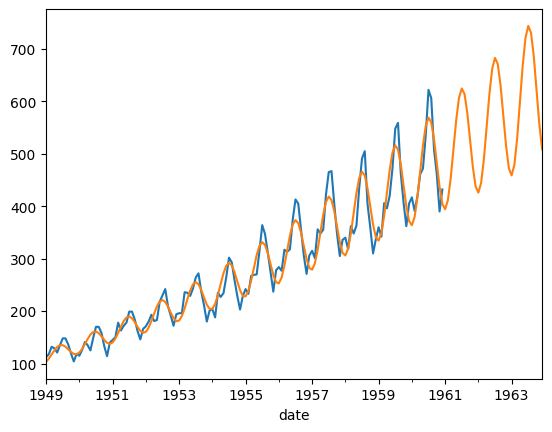

In [32]:
passengers['num_passengers'].plot()
passengers_forecast['num_passengers'].plot()
plt.show()

### Остатки модели с добавлением квадратичного тренда

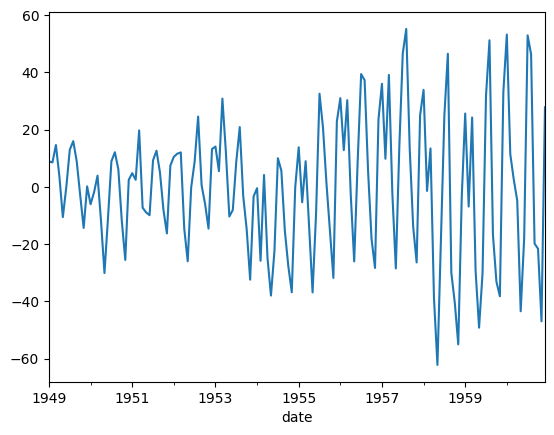

In [33]:
resids = (passengers['num_passengers'] - passengers_forecast['num_passengers']['1949-01-01':'1960-12-01'])
resids.plot()
plt.show()

In [34]:
adfuller(resids)[1] 

0.0357082513323185

p-value < 0.05, осатки на данном этапе уже являются стационарным рядом.

## 4. Добавление компонент сезонности в модель для более точного прогноза

In [35]:
passengers['sin(4*pi*(i-1)/12)'] = [sin(4 * pi * (i-1) / 12) for i in passengers['t'].values]
passengers['cos(4*pi*(i-1)/12)'] = [cos(4 * pi * (i-1) / 12) for i in passengers['t'].values]

passengers['t*sin2'] = [passengers['t'].values[i] * passengers['sin(4*pi*(i-1)/12)'].values[i] for i in range(passengers.shape[0])]
passengers['t*cos2'] = [passengers['t'].values[i] * passengers['cos(4*pi*(i-1)/12)'].values[i] for i in range(passengers.shape[0])]

passengers['t^2*sin2'] = [passengers['t^2'].values[i] * passengers['sin(4*pi*(i-1)/12)'].values[i] for i in range(passengers.shape[0])]
passengers['t^2*cos2'] = [passengers['t^2'].values[i] * passengers['cos(4*pi*(i-1)/12)'].values[i] for i in range(passengers.shape[0])]

In [36]:
linregr = sm.GLM(endog=passengers['num_passengers'].values, 
                 exog=passengers.drop('num_passengers', axis=1).values, 
                 family=sm.families.Gaussian()).fit()

In [37]:
linregr.params

array([ 1.13177080e+02,  1.67395027e+00,  1.04530931e+01, -5.40433032e+00,
        1.77506703e-01, -2.43793088e-01,  6.90961051e-03,  5.25093705e-04,
       -2.07821202e-03,  1.30940134e+00,  1.08577803e+01, -4.97887837e-02,
        6.11146889e-02, -9.97030397e-04,  1.04949771e-03])

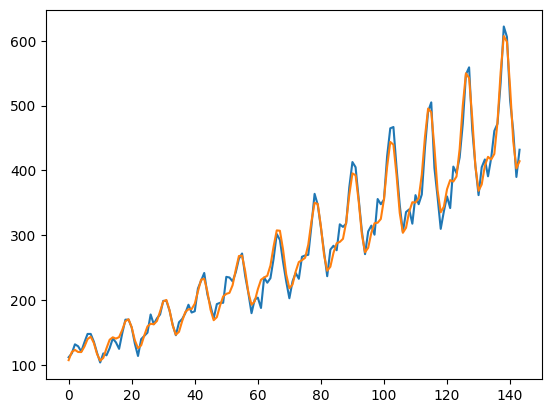

In [38]:
plt.plot(passengers['num_passengers'].values)
plt.plot(linregr.fittedvalues)
plt.show()

### Еще одну сезонную компоненту

In [39]:
passengers['sin(8*pi*(i-1)/12)'] = [sin(8 * pi * (i-1) / 12) for i in passengers['t'].values]
passengers['cos(8*pi*(i-1)/12)'] = [cos(8 * pi * (i-1) / 12) for i in passengers['t'].values]

passengers['t*sin3'] = [passengers['t'].values[i] * passengers['sin(8*pi*(i-1)/12)'].values[i] for i in range(passengers.shape[0])]
passengers['t*cos3'] = [passengers['t'].values[i] * passengers['cos(8*pi*(i-1)/12)'].values[i] for i in range(passengers.shape[0])]

passengers['t^2*sin3'] = [passengers['t^2'].values[i] * passengers['sin(8*pi*(i-1)/12)'].values[i] for i in range(passengers.shape[0])]
passengers['t^2*cos3'] = [passengers['t^2'].values[i] * passengers['cos(8*pi*(i-1)/12)'].values[i] for i in range(passengers.shape[0])]

In [40]:
linregr = sm.GLM(endog=passengers['num_passengers'].values, 
                 exog=passengers.drop('num_passengers', axis=1).values, 
                 family=sm.families.Gaussian()).fit()

In [41]:
passengers.head()

,num_passengers,const,t,sin(2pi*(i-1)/s),cos(2pi*(i-1)/s),t*sin,t*cos,t^2,t^2*sin,t^2*cos,...,t*sin2,t*cos2,t^2*sin2,t^2*cos2,sin(8*pi*(i-1)/12),cos(8*pi*(i-1)/12),t*sin3,t*cos3,t^2*sin3,t^2*cos3
date,,,,,,,,,,,,,,,,,,,,,
1949-01-01,112,1,0,-0.500000,8.660254e-01,-0.000000,0.000000e+00,0,-0.000000,0.000000e+00,...,-0.000000e+00,0.0,-0.000000e+00,0.0,-8.660254e-01,-0.5,-0.000000e+00,-0.0,-0.000000e+00,-0.0
1949-02-01,118,1,1,0.000000,1.000000e+00,0.000000,1.000000e+00,1,0.000000,1.000000e+00,...,0.000000e+00,1.0,0.000000e+00,1.0,0.000000e+00,1.0,0.000000e+00,1.0,0.000000e+00,1.0
1949-03-01,132,1,2,0.500000,8.660254e-01,1.000000,1.732051e+00,4,2.000000,3.464102e+00,...,1.732051e+00,1.0,3.464102e+00,2.0,8.660254e-01,-0.5,1.732051e+00,-1.0,3.464102e+00,-2.0
1949-04-01,129,1,3,0.866025,5.000000e-01,2.598076,1.500000e+00,9,7.794229,4.500000e+00,...,2.598076e+00,-1.5,7.794229e+00,-4.5,-8.660254e-01,-0.5,-2.598076e+00,-1.5,-7.794229e+00,-4.5
1949-05-01,121,1,4,1.000000,6.123234e-17,4.000000,2.449294e-16,16,16.000000,9.797174e-16,...,4.898587e-16,-4.0,1.959435e-15,-16.0,-2.449294e-16,1.0,-9.797174e-16,4.0,-3.918870e-15,16.0


In [42]:
linregr.params

array([ 1.13255273e+02,  1.66910150e+00,  1.03234502e+01, -5.29659364e+00,
        1.85586252e-01, -2.50439962e-01,  6.95352888e-03,  4.51910578e-04,
       -2.01798736e-03,  1.09225381e+00,  1.08131615e+01, -3.63373616e-02,
        6.35896966e-02, -1.11874019e-03,  1.02833833e-03, -3.65322406e-01,
       -1.80646577e+00,  1.36709966e-01, -1.49289082e-01, -1.36411097e-03,
        7.17496447e-04])

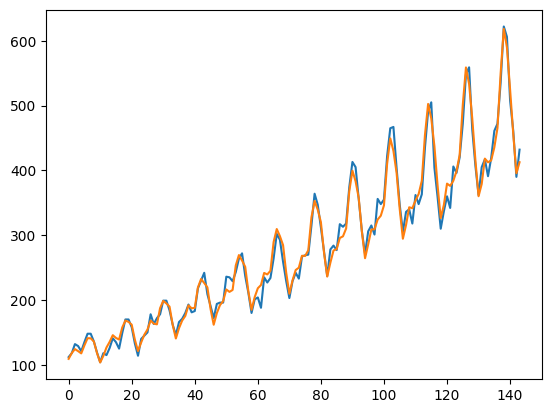

In [43]:
plt.plot(passengers['num_passengers'].values)
plt.plot(linregr.fittedvalues)
plt.show()

### Итоговый прогноз

In [44]:
passengers_forecast['sin(4*pi*(i-1)/12)'] = [sin(4 * pi * (i-1) / 12) for i in passengers_forecast['t'].values]
passengers_forecast['cos(4*pi*(i-1)/12)'] = [cos(4 * pi * (i-1) / 12) for i in passengers_forecast['t'].values]

passengers_forecast['t*sin2'] = [passengers_forecast['t'].values[i] * passengers_forecast['sin(4*pi*(i-1)/12)'].values[i] for i in range(passengers_forecast.shape[0])]
passengers_forecast['t*cos2'] = [passengers_forecast['t'].values[i] * passengers_forecast['cos(4*pi*(i-1)/12)'].values[i] for i in range(passengers_forecast.shape[0])]

passengers_forecast['t^2*sin2'] = [passengers_forecast['t^2'].values[i] * passengers_forecast['sin(4*pi*(i-1)/12)'].values[i] for i in range(passengers_forecast.shape[0])]
passengers_forecast['t^2*cos2'] = [passengers_forecast['t^2'].values[i] * passengers_forecast['cos(4*pi*(i-1)/12)'].values[i] for i in range(passengers_forecast.shape[0])]

passengers_forecast['sin(8*pi*(i-1)/12)'] = [sin(8 * pi * (i-1) / 12) for i in passengers_forecast['t'].values]
passengers_forecast['cos(8*pi*(i-1)/12)'] = [cos(8 * pi * (i-1) / 12) for i in passengers_forecast['t'].values]

passengers_forecast['t*sin3'] = [passengers_forecast['t'].values[i] * passengers_forecast['sin(8*pi*(i-1)/12)'].values[i] for i in range(passengers_forecast.shape[0])]
passengers_forecast['t*cos3'] = [passengers_forecast['t'].values[i] * passengers_forecast['cos(8*pi*(i-1)/12)'].values[i] for i in range(passengers_forecast.shape[0])]

passengers_forecast['t^2*sin3'] = [passengers_forecast['t^2'].values[i] * passengers_forecast['sin(8*pi*(i-1)/12)'].values[i] for i in range(passengers_forecast.shape[0])]
passengers_forecast['t^2*cos3'] = [passengers_forecast['t^2'].values[i] * passengers_forecast['cos(8*pi*(i-1)/12)'].values[i] for i in range(passengers_forecast.shape[0])]

In [45]:
passengers_forecast['num_passengers'] = linregr.predict(passengers_forecast.drop('num_passengers', axis=1))

<Axes: xlabel='date'>

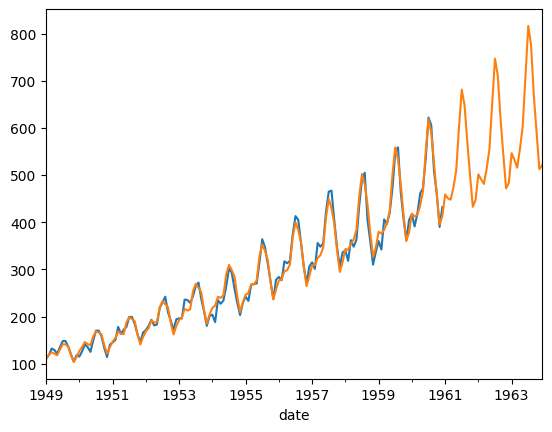

In [46]:
passengers['num_passengers'].plot()
passengers_forecast['num_passengers'].plot()